## Persistence Landscapes

- vectorized representations of persistence diagrams

- per homology group rank (ex H0, H1, or H2)
- per stimuli
- per region
- difference landscapes

Author: @emilyekstrum
<br> 11/26/25

In [1]:
# import modules
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from persim import PersLandscapeApprox
from persim import persistent_entropy
from persim.landscapes import average_approx
from persim.landscapes import snap_pl
from persim.landscapes import plot_landscape_simple
from persim.landscapes import plot_landscape
import random
import os
from matplotlib.lines import Line2D
import numpy as np
from typing import Optional, Tuple, Sequence, Any
from sklearn.decomposition import PCA
from ripser import ripser
from persim import wasserstein
from sklearn.neighbors import NearestNeighbors    
from scipy.sparse import coo_matrix    

In [2]:
# import TDA utilities
import sys
from pathlib import Path

repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

try:
    from tda_utils import TDADataManager, tda_manager
    print("TDA utilities loaded")
except ImportError as e:
    print(f"Could not import TDA utilities: {e}")
    print("Make sure you're running from the TDA repository.")
    raise

# initialize or use the global data manager
if tda_manager is not None:
    data_manager = tda_manager
else:
    data_manager = TDADataManager()

# summary of available data
data_manager.print_summary()

Spike data already available.
Extracting persistence diagrams from all_dgms.zip...
Extracted to: /Users/emilyekstrum/repos/TDA/data/all_dgms
TDA utilities loaded
TDA Data Manager Summary
Workspace root: /Users/emilyekstrum/repos/TDA
Data directory: /Users/emilyekstrum/repos/TDA/data
  - clean_spike_data_zip: clean_spike_data.zip
  - clean_spike_data_dir: clean_spike_data
      Contains 8 .pkl files
  - cebra_examples: CEBRA_embedding_examples
      Contains 4 .pkl files
  - persistence_examples: persistence_diagram_examples
      Contains 22 .pkl files
  - all_dgms_zip: all_dgms.zip
  X all_dgms_dir: all_dgms

Available spike datasets (8):
  • LGNchromatic_gratings.pkl
  • LGNcolor_exchange.pkl
  • LGNdrifting_gratings.pkl
  • LGNluminance_flash.pkl
  • V1chromatic_gratings.pkl
  and 3 more


![image.png](attachment:image.png)

# Plot interpretation

In [3]:
# set primary data directory based on available files
all_persistence_files = data_manager.find_files("*.pkl", "persistence_examples")

if all_persistence_files:
    # use the directory of the first file as primary, but search all
    data_dir = all_persistence_files[0].parent
    print(f"Primary data directory: {data_dir}")
    print(f"Total persistence files available: {len(all_persistence_files)}")
    
    # check if there are files from all_dgms (more comprehensive dataset)
    all_dgms_files = [f for f in all_persistence_files if 'all_dgms' in str(f)]
    if all_dgms_files:
        print(f"Files from all_dgms.zip: {len(all_dgms_files)}")
    
    # check persistence_examples files
    examples_files = [f for f in all_persistence_files if 'persistence_diagram_examples' in str(f)]
    if examples_files:
        print(f"Files from persistence_examples: {len(examples_files)}")
        
else:
    # use original directory
    data_dir = data_manager.data_paths['persistence_examples']
    print(f"Getting dgms files from: {data_dir}")

# stimulus mapping 
stim_map = {
    "dg": "drifting_gratings",
    "cg": "chromatic_gratings",
    "cex": "color_exchange",
    "lf": "luminance_flash",
    "ng": "natural_gratings",
    "nm": "natural_movie",
    "rf": "receptive_field",
    "sp": "sparse_noise"
}

def parse_filename(fname: str):
    """ Enhanced filename parser for comprehensive dataset support.
    
    Args:
        fname (str): filename
    Returns:
        dict: method, embed_dim, region, stim, mouse"""

    # TDA utils for parsing
    info = data_manager.parse_filename_info(fname)
    
    return {
        "method": "CEBRA",  
        "embed_dim": info['dimension'],
        "region": info['region'],
        "stim": info['stimulus'],
        "mouse": info['mouse_id'],
    }

def load_dgms(path):
    """ Enhanced diagram loader that works with all file sources.
    
    Args:
        path (str or Path): path to pickle file (can be relative name or full path)
    Returns:
        list: diagrams"""

    # handle full paths and filenames
    if isinstance(path, str) and not path.startswith('/'):
        # find the full path of file name
        matching_files = [f for f in all_persistence_files if f.name == path]
        if matching_files:
            path = matching_files[0]
        else:
            # try in the primary data directory
            path = data_dir / path
    
    return data_manager.load_persistence_diagrams(path)

Primary data directory: /Users/emilyekstrum/repos/TDA/data/persistence_diagram_examples
Total persistence files available: 22
Files from persistence_examples: 22


In [4]:
# load all available persistence diagram files from multiple sources
available_files = data_manager.find_files("*.pkl", "persistence_examples")

if available_files:
    
    # organize by region, stimulus, and dimension 
    file_organization = {}
    dimension_counts = {}
    stimulus_counts = {}
    
    for file_path in available_files:
        info = data_manager.parse_filename_info(file_path)
        region = info['region']
        stimulus = info['stimulus']
        dimension = info['dimension']
        
        # count by categories
        key = f"{region}_{stimulus}"
        if key not in file_organization:
            file_organization[key] = []
        file_organization[key].append(file_path)
        
        # track dimensions and stimuli
        dimension_counts[dimension] = dimension_counts.get(dimension, 0) + 1
        stimulus_counts[stimulus] = stimulus_counts.get(stimulus, 0) + 1
    
    print(f"\nAvailable data combinations:")
    for combo, files in sorted(file_organization.items()):
        region, stim = combo.split('_', 1)
        dimensions_in_combo = sorted(set(data_manager.parse_filename_info(f)['dimension'] for f in files),
                                   key=lambda x: int(x[:-1]) if x[:-1].isdigit() else 999)
        print(f"  • {region} - {stim.replace('_', ' ').title()}: {len(files)} files ({', '.join(dimensions_in_combo)})")
        
    # separate lists for each region (maintaining backward compatibility)
    LGN_files = [f.name for f in available_files if data_manager.parse_filename_info(f)['region'] == 'LGN']
    V1_files = [f.name for f in available_files if data_manager.parse_filename_info(f)['region'] == 'V1']
    
    print(f"\nCompatibility lists:")
    print(f"   LGN files: {len(LGN_files)}")
    print(f"   V1 files: {len(V1_files)}")
    
else:
    print("No persistence diagram files found.")
    print("Error checklist:")
    print("  1. Run the Ripser notebook (02_Ripser.ipynb) to generate persistence diagrams")
    print("  2. Put all_dgms.zip in the data/ directory")
    print("  3. Add .pkl files directly to data/persistence_diagram_examples/")
    LGN_files = []
    V1_files = []


Available data combinations:
  • LGN - Color Exchange: 8 files (3d, 8d, 24d, 32d)
  • V1 - Color Exchange: 14 files (3d, 8d, 24d, 32d)

Compatibility lists:
   LGN files: 8
   V1 files: 14


## Average PLs by region

In [5]:
# average landscapes for each homology group (H0, H1, H2) - WITH DEBUGGING
if available_files:
    
    avg_lgn_landscapes = {}
    avg_v1_landscapes = {}

    print(f"Starting landscape computation with {len(LGN_files)} LGN files and {len(V1_files)} V1 files")
    print(f"Data directory: {data_dir}")
    
    for hom_deg in range(3): 
        print(f"\n  Processing H{hom_deg}")
        LGN_landscape = []
        V1_landscape = []
        
        # LGN files - with detailed debugging
        lgn_count = 0
        lgn_errors = 0
        lgn_empty = 0
        
        for f in LGN_files:
            try:
                fpath = data_dir / f
                print(f"    Loading LGN file: {f}")
                
                if not fpath.exists():
                    print(f"      File not found: {fpath}")
                    continue
                    
                dgms = load_dgms(fpath)
                print(f"      Loaded diagrams: {type(dgms)}, length: {len(dgms) if dgms else 0}")
                
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                    
                if dgms and len(dgms) > hom_deg:
                    current_dgm = dgms[hom_deg]
                    print(f"      H{hom_deg} diagram: {type(current_dgm)}, size: {len(current_dgm) if current_dgm is not None else 0}")
                    
                    if current_dgm is not None and len(current_dgm) > 0:
                        persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                        LGN_landscape.append(persistence_landscape)
                        lgn_count += 1
                        print(f"       Landscape created successfully")
                    else:
                        lgn_empty += 1
                        print(f"      Empty H{hom_deg} diagram")
                else:
                    lgn_empty += 1
                    print(f"      Insufficient homology degrees or empty diagrams")
                    
            except Exception as e:
                lgn_errors += 1
                print(f"      Error processing {f}: {e}")
                continue
        
        print(f"    LGN H{hom_deg} summary: {lgn_count} landscapes, {lgn_empty} empty, {lgn_errors} errors")
        
        # V1 files - with detailed debugging
        v1_count = 0
        v1_errors = 0
        v1_empty = 0
        
        for f in V1_files:
            try:
                fpath = data_dir / f
                print(f"    Loading V1 file: {f}")
                
                if not fpath.exists():
                    print(f"      File not found: {fpath}")
                    continue
                    
                dgms = load_dgms(fpath)
                print(f"      Loaded diagrams: {type(dgms)}, length: {len(dgms) if dgms else 0}")
                
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                    
                if dgms and len(dgms) > hom_deg:
                    current_dgm = dgms[hom_deg]
                    print(f"      🔬 H{hom_deg} diagram: {type(current_dgm)}, size: {len(current_dgm) if current_dgm is not None else 0}")
                    
                    if current_dgm is not None and len(current_dgm) > 0:
                        persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                        V1_landscape.append(persistence_landscape)
                        v1_count += 1
                        print(f"      Landscape created successfully")
                    else:
                        v1_empty += 1
                        print(f"      Empty H{hom_deg} diagram")
                else:
                    v1_empty += 1
                    print(f"      Insufficient homology degrees or empty diagrams")
                    
            except Exception as e:
                v1_errors += 1
                print(f"       Error processing {f}: {e}")
                continue
        
        print(f"     V1 H{hom_deg} summary: {v1_count} landscapes, {v1_empty} empty, {v1_errors} errors")
        
        # average persistence landscapes 
        if LGN_landscape:
            try:
                avg_lgn_landscapes[f'H{hom_deg}'] = average_approx(LGN_landscape)
                print(f"    LGN H{hom_deg}: {lgn_count} landscapes averaged successfully")
            except Exception as e:
                print(f"    LGN H{hom_deg}: Failed to average landscapes - {e}")
                
        if V1_landscape:
            try:
                avg_v1_landscapes[f'H{hom_deg}'] = average_approx(V1_landscape)
                print(f"    V1 H{hom_deg}: {v1_count} landscapes averaged successfully")
            except Exception as e:
                print(f"    V1 H{hom_deg}: Failed to average landscapes - {e}")
    
    print(f" LGN landscapes created: {list(avg_lgn_landscapes.keys())}")
    print(f" V1 landscapes created: {list(avg_v1_landscapes.keys())}")
    
    # save individual landscape variables
    avg_lgn_h0_landscape = avg_lgn_landscapes.get('H0')
    avg_lgn_h1_landscape = avg_lgn_landscapes.get('H1')
    avg_lgn_h2_landscape = avg_lgn_landscapes.get('H2')
    avg_v1_h0_landscape = avg_v1_landscapes.get('H0')
    avg_v1_h1_landscape = avg_v1_landscapes.get('H1')
    avg_v1_h2_landscape = avg_v1_landscapes.get('H2')
    
    # Test one landscape to see its structure
    if avg_lgn_landscapes:
        test_landscape = next(iter(avg_lgn_landscapes.values()))
        if test_landscape:
            print(f"\n Sample landscape structure:")
            print(f"   Type: {type(test_landscape)}")
            print(f"   Has landscapes attr: {hasattr(test_landscape, 'landscapes')}")
            if hasattr(test_landscape, 'landscapes'):
                print(f"   Number of layers: {len(test_landscape.landscapes)}")
                print(f"   Layer 0 size: {len(test_landscape.landscapes[0]) if test_landscape.landscapes else 0}")
    
else:
    print("No files available for landscape computation.")

Starting landscape computation with 8 LGN files and 14 V1 files
Data directory: /Users/emilyekstrum/repos/TDA/data/persistence_diagram_examples

  Processing H0
    Loading LGN file: CEBRA_32d_LGN_cex_C153.pkl
      Loaded diagrams: <class 'list'>, length: 3
      H0 diagram: <class 'numpy.ndarray'>, size: 10000
       Landscape created successfully
    Loading LGN file: CEBRA_3d_LGN_cex_C153.pkl
      Loaded diagrams: <class 'list'>, length: 3
      H0 diagram: <class 'numpy.ndarray'>, size: 10000
       Landscape created successfully
    Loading LGN file: CEBRA_8d_LGN_cex_C159.pkl
      Loaded diagrams: <class 'list'>, length: 3
      H0 diagram: <class 'numpy.ndarray'>, size: 5000
       Landscape created successfully
    Loading LGN file: CEBRA_24d_LGN_cex_C159.pkl
      Loaded diagrams: <class 'list'>, length: 3
      H0 diagram: <class 'numpy.ndarray'>, size: 10000
       Landscape created successfully
    Loading LGN file: CEBRA_24d_LGN_cex_C153.pkl
      Loaded diagrams: <class

In [ ]:
# create landscapes organized by stimulus
if available_files:
    # get available stimuli from the data
    available_stimuli = set()
    for file_path in available_files:
        info = data_manager.parse_filename_info(file_path)
        available_stimuli.add(info['stimulus'])
    
    print(f"Available stimuli: {sorted(available_stimuli)}")
    
    # create stimulus-based landscapes
    landscapes_by_stimulus = {}
    
    for hom_deg in range(3):
        print(f"\nProcessing H{hom_deg} landscapes by stimulus...")
        
        for stimulus in available_stimuli:
            stimulus_files = [f for f in available_files if data_manager.parse_filename_info(f)['stimulus'] == stimulus]
            
            lgn_files = [f for f in stimulus_files if data_manager.parse_filename_info(f)['region'] == 'LGN']
            v1_files = [f for f in stimulus_files if data_manager.parse_filename_info(f)['region'] == 'V1']
            
            # create landscapes for each region
            for region, files in [('LGN', lgn_files), ('V1', v1_files)]:
                if not files:
                    continue
                    
                landscapes = []
                for file_path in files:
                    try:
                        dgms = load_dgms(file_path)
                        if dgms and len(dgms) > hom_deg and dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                            pl = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                            landscapes.append(pl)
                    except Exception as e:
                        print(f"      Error processing {file_path.name}: {e}")
                        continue
                
                if landscapes:
                    try:
                        avg_landscape = average_approx(landscapes)
                        key = f"{region}_{stimulus}_H{hom_deg}"
                        landscapes_by_stimulus[key] = avg_landscape
                        print(f"    Created {key} with {len(landscapes)} landscapes")
                    except Exception as e:
                        print(f"    Failed to create average for {region}_{stimulus}_H{hom_deg}: {e}")
    
    print(f"\nCreated {len(landscapes_by_stimulus)} stimulus-based landscapes")
    print(f"Keys: {list(landscapes_by_stimulus.keys())}")
    
else:
    landscapes_by_stimulus = {}
    print("No files available for stimulus-based landscape computation.")

Available stimuli: ['color_exchange']

Processing H0 landscapes by stimulus...
    Created LGN_color_exchange_H0 with 8 landscapes
    Created V1_color_exchange_H0 with 14 landscapes

Processing H1 landscapes by stimulus...
    Created LGN_color_exchange_H1 with 8 landscapes
    Created V1_color_exchange_H1 with 14 landscapes

Processing H2 landscapes by stimulus...
    Created LGN_color_exchange_H2 with 8 landscapes
    Created V1_color_exchange_H2 with 14 landscapes

Created 6 stimulus-based landscapes
Keys: ['LGN_color_exchange_H0', 'V1_color_exchange_H0', 'LGN_color_exchange_H1', 'V1_color_exchange_H1', 'LGN_color_exchange_H2', 'V1_color_exchange_H2']


In [ ]:
# utils for AUC

def landscape_auc_persim_any(pl, n_layers=None, x_min=None, x_max=None, n_bins=None, return_per_layer=False):
    """
    Compute AUC for a persim PersLandscapeApprox object

    Args:
        pl: PersLandscapeApprox object
        n_layers: int number of lambda function layers to include in AUC calculation
        x_min: float minimum x value to include in AUC calculation
        x_max: float maximum x value to include in AUC calculation
        n_bins: int number of bins to use in AUC calculation
        return_per_layer: bool whether to return per-layer AUCs

    Returns:
        total_auc: float total AUC
        per_layer_auc: np.ndarray per-layer AUCs"""

    Y_native = _get_Y_from_pl(pl) 
    # normalize to (layers, points)
    if Y_native.ndim == 1:
        Y_native = Y_native[None, :]
    # guess x-grid length
    n_points = Y_native.shape[-1]
    xs_native = _get_xs_from_pl(pl, n_points_hint=n_points)

    # If orientation is (points, layers), transpose
    if Y_native.shape[0] == xs_native.size and Y_native.shape[1] != xs_native.size:
        Y_native = Y_native.T

    # option to limit number of layers included in AUC calculation
    if n_layers is not None:
        Y_native = Y_native[:n_layers, :]

    # integration window
    if x_min is None: x_min = float(xs_native.min())
    if x_max is None: x_max = float(xs_native.max())
    if x_min >= x_max:
        raise ValueError("x_min must be < x_max.")

    mask = (xs_native >= x_min) & (xs_native <= x_max)
    xs = xs_native[mask]
    Y = Y_native[:, mask]

    # optional resampling to uniform count
    if n_bins is not None and n_bins > 1:
        xs_uniform = np.linspace(x_min, x_max, int(n_bins))
        Y = np.vstack([np.interp(xs_uniform, xs, y) for y in Y])
        xs = xs_uniform

    # integrate
    Y = np.nan_to_num(Y, copy=False)
    per_layer_auc = np.trapz(Y, xs, axis=1)
    total_auc = float(per_layer_auc.sum())

    return (total_auc, per_layer_auc) if return_per_layer else (total_auc, None)
    
def _get_xs_from_pl(pl, n_points_hint):
    """ Get x-values from a PersLandscapeApprox object

    Args:
        pl: PersLandscapeApprox object
        n_points_hint: int number of points to use in x-grid
    Returns:
        np.ndarray x-values"""

    for attr in ("grid", "xs", "x_values"):
        xs = getattr(pl, attr, None)
        if xs is not None:
            return np.asarray(xs).ravel()

    # try start/stop/num_steps trio
    if all(hasattr(pl, a) for a in ("start", "stop", "num_steps")):
        return np.linspace(float(pl.start), float(pl.stop), int(pl.num_steps))

    # try x_range
    xr = getattr(pl, "x_range", None)
    if xr is not None and n_points_hint is not None:
        return np.linspace(float(xr[0]), float(xr[1]), int(n_points_hint))

    # or just make an index grid
    if n_points_hint is not None:
        return np.arange(int(n_points_hint), dtype=float)

    raise TypeError("Could not infer x-grid from PersLandscapeApprox (no grid/xs/start/stop/num_steps/x_range).")


def _get_Y_from_pl(pl):
    """ Get Y-values from a PersLandscapeApprox object

    Args:
        pl: PersLandscapeApprox object
    Returns:
        np.ndarray Y-values"""

    for attr in ("values", "landscapes", "Ls", "y_values", "_values", "_landscapes"):
        Y = getattr(pl, attr, None)
        if Y is not None:
            Y = np.asarray(Y, dtype=float)
            return Y

    raise TypeError("Could not extract landscape values from PersLandscapeApprox (no values/landscapes/Ls).")

# AUC, peak position, and layer count across embedding dimensions and stimuli
hom_deg = 1
embedding_dims = ['3d', '8d', '24d', '32d']
stim_code_map = {
    'color_exchange': 'Color Exchange',
    'luminance_flash': 'Luminance Flash',
    'drifting_gratings': 'Drifting Gratings',
    'chromatic_gratings': 'Chromatic Gratings'
}
regions = ['LGN', 'V1']

metrics_records = []

# use data manager to find files instead of os.listdir
for dim_label in embedding_dims:
    dim_value = int(dim_label.replace('d', ''))
    for region in regions:
        for stim_full_name, stim_display_name in stim_code_map.items():
            # find matching files using data manager
            matching_files = []
            for file_path in available_files:
                info = data_manager.parse_filename_info(file_path)
                if (info['dimension'] == dim_label and 
                    info['region'] == region and 
                    info['stimulus'] == stim_full_name):
                    matching_files.append(file_path)

            landscape_entries = []
            for file_path in matching_files:
                dgms = load_dgms(file_path)
                if dgms is None:
                    continue
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                if len(dgms) <= hom_deg:
                    continue
                if dgms[hom_deg] is None or len(dgms[hom_deg]) == 0:
                    continue
                try:
                    pl = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                    landscape_entries.append((file_path.name, pl))
                except Exception:
                    continue

            if not landscape_entries:
                continue

            pls = [pl for _, pl in landscape_entries]
            try:
                if len(pls) > 1:
                    aligned_pls = snap_pl(pls)
                else:
                    aligned_pls = pls
            except Exception:
                aligned_pls = pls

            def count_diagrams_for_pl(pl, hom_deg):
                """Count diagrams in a persistence landscape"""
                for attr in ('dgms', '_dgms', 'diagrams', '_diagrams'):
                    if hasattr(pl, attr):
                        diag_source = getattr(pl, attr)
                        if diag_source is not None:
                            if isinstance(diag_source, dict):
                                diag_source = diag_source.get(hom_deg, [])
                            if isinstance(diag_source, (list, tuple)):
                                if len(diag_source) > hom_deg and hasattr(diag_source[hom_deg], '__len__'):
                                    return len(diag_source[hom_deg])
                            return 1
                return 1

            for (fname, orig_pl), snapped_pl in zip(landscape_entries, aligned_pls):
                try:
                    auc_val, _ = landscape_auc_persim_any(snapped_pl)
                except Exception:
                    auc_val = np.nan

                try:
                    Y = _get_Y_from_pl(snapped_pl)
                    if Y.ndim == 1:
                        Y = Y[None, :]
                    xs = _get_xs_from_pl(snapped_pl, n_points_hint=Y.shape[-1])
                    if Y.shape[0] == xs.size and Y.shape[1] != xs.size:
                        Y = Y.T
                    Y = np.nan_to_num(Y, nan=0.0, posinf=0.0, neginf=0.0)
                    y_max_per_layer = np.max(Y, axis=1)
                    layer_count = int(np.sum(y_max_per_layer > 1e-6))
                    peak_idx = np.argmax(Y)
                    peak_pos = float(xs[np.unravel_index(peak_idx, Y.shape)[-1]])
                except Exception:
                    peak_pos = np.nan
                    layer_count = np.nan

                metrics_records.append({
                    'region': region,
                    'stimulus': stim_display_name,
                    'stim_code': stim_full_name,
                    'dimension': dim_label,
                    'dimension_numeric': dim_value,
                    'auc': auc_val,
                    'peak_position': peak_pos,
                    'layer_count': layer_count,
                    'diagram_count': count_diagrams_for_pl(orig_pl, hom_deg),
                    'file': fname
                })

topo_metrics_df = pd.DataFrame(metrics_records)

if topo_metrics_df.empty:
    print('No metrics could be computed for the selected configuration.')
else:
    summary_df = (
        topo_metrics_df
        .groupby(['region', 'stimulus', 'stim_code', 'dimension', 'dimension_numeric'], as_index=False)
        .agg(
            auc_mean=('auc', 'mean'),
            auc_std=('auc', 'std'),
            auc_count=('auc', 'count'),
            peak_position_mean=('peak_position', 'mean'),
            peak_position_std=('peak_position', 'std'),
            peak_position_count=('peak_position', 'count'),
            layer_count_mean=('layer_count', 'mean'),
            layer_count_std=('layer_count', 'std'),
            layer_count_count=('layer_count', 'count'),
            diagram_count=('diagram_count', 'sum')
        )
    )

    display(summary_df.head())

/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_602/1313498630.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  per_layer_auc = np.trapz(Y, xs, axis=1)


,region,stimulus,stim_code,dimension,dimension_numeric,auc_mean,auc_std,auc_count,peak_position_mean,peak_position_std,peak_position_count,layer_count_mean,layer_count_std,layer_count_count,diagram_count
0,LGN,Color Exchange,color_exchange,24d,24,0.018341,0.001721,2,0.079817,0.015221,2,713.5,86.974134,2,2
1,LGN,Color Exchange,color_exchange,32d,32,0.004543,0.002211,2,0.072508,0.032337,2,746.5,409.414826,2,2
2,LGN,Color Exchange,color_exchange,3d,3,0.000681,0.000873,2,0.035293,0.014905,2,344.0,465.276262,2,2
3,LGN,Color Exchange,color_exchange,8d,8,0.003766,0.001454,2,0.168916,0.184414,2,610.0,642.052957,2,2
4,V1,Color Exchange,color_exchange,24d,24,0.003764,NaN,1,0.065206,NaN,1,419.0,NaN,1,1


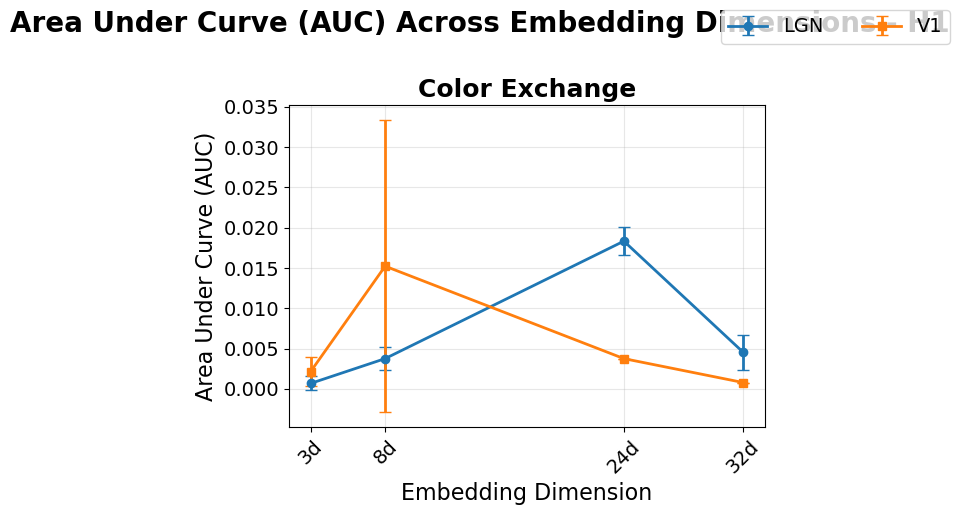

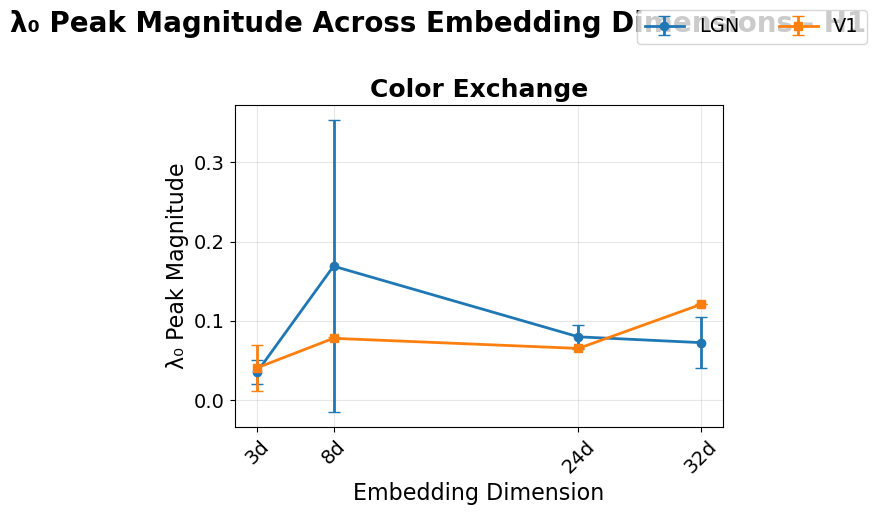

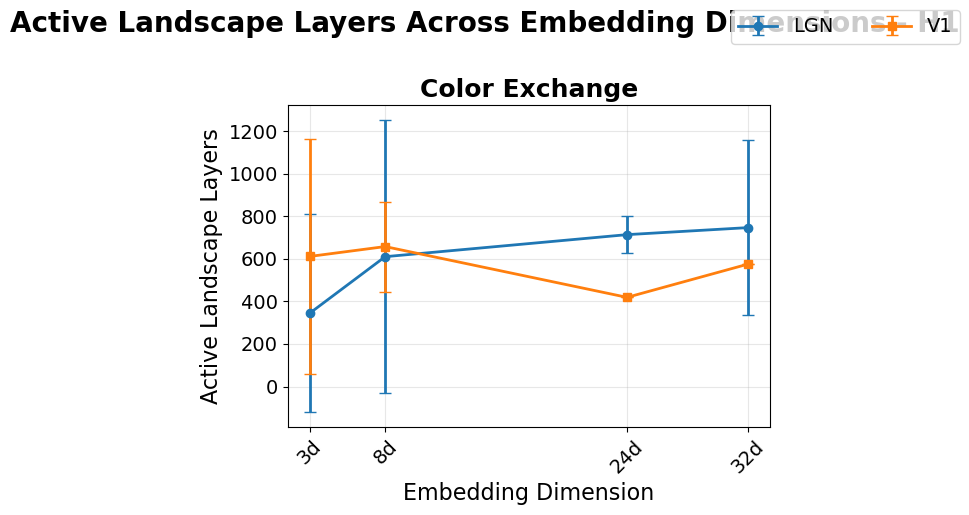

In [ ]:
# plots for AUC, peak position, and layer count across embedding dimensions

if 'topo_metrics_df' in locals() and not topo_metrics_df.empty and 'summary_df' in locals() and not summary_df.empty:
    dim_numeric_order = [int(d.replace('d', '')) for d in embedding_dims]
    dim_label_map = dict(zip(dim_numeric_order, embedding_dims))
    
    # get available stimuli from the data
    available_stimuli_in_metrics = sorted(summary_df['stimulus'].unique())
    
    region_styles = {
        'LGN': {'color': 'tab:blue', 'marker': 'o'},
        'V1': {'color': 'tab:orange', 'marker': 's'}
    }

    metric_specs = [
        ('auc', 'Area Under Curve (AUC)'),
        ('peak_position', 'λ\u2080 Peak Magnitude'),
        ('layer_count', 'Active Landscape Layers')
    ]

    for metric, metric_label in metric_specs:
        mean_col = f'{metric}_mean'
        std_col = f'{metric}_std'

        n_stim_plots = len(available_stimuli_in_metrics)
        fig, axes = plt.subplots(1, n_stim_plots, figsize=(6*n_stim_plots, 5), sharey=False)
        if n_stim_plots == 1:
            axes = [axes]

        legend_handles = {}

        for ax, stim in zip(axes, available_stimuli_in_metrics):
            stim_data = summary_df[summary_df['stimulus'] == stim]
            for region, style in region_styles.items():
                region_data = (
                    stim_data[stim_data['region'] == region]
                    .sort_values('dimension_numeric')
                )
                if region_data.empty:
                    continue
                y = region_data[mean_col]
                yerr = region_data[std_col].fillna(0.0)
                counts = region_data['diagram_count'].fillna(0).astype(int)
                handle = ax.errorbar(
                    region_data['dimension_numeric'],
                    y,
                    yerr=yerr,
                    label=region,
                    color=style['color'],
                    marker=style['marker'],
                    linewidth=2,
                    capsize=4
                )
                legend_handles[region] = handle

            ax.set_title(stim, fontsize=18, fontweight='bold')
            ax.set_xlabel('Embedding Dimension', fontsize=16)
            ax.grid(alpha=0.3)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.set_xticks(dim_numeric_order)
            ax.set_xticklabels([dim_label_map[d] for d in dim_numeric_order if d in dim_label_map], rotation=45)
        
        axes[0].set_ylabel(metric_label, fontsize=16)

        if legend_handles:
            fig.legend(legend_handles.values(), legend_handles.keys(), 
                      loc='upper right', ncol=len(region_styles), fontsize=14)
        fig.suptitle(f'{metric_label} Across Embedding Dimensions - H{hom_deg}', 
                    fontsize=20, y=1.02, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print('No data available for plotting metrics across embedding dimensions.')

Processing LGN H0...
  Created LGN H0 with 8 landscapes
Processing LGN H1...
  Created LGN H1 with 8 landscapes
Processing LGN H2...
  Created LGN H0 with 8 landscapes
Processing LGN H1...
  Created LGN H1 with 8 landscapes
Processing LGN H2...
  Created LGN H2 with 8 landscapes
Processing V1 H0...
  Created LGN H2 with 8 landscapes
Processing V1 H0...
  Created V1 H0 with 14 landscapes
Processing V1 H1...
  Created V1 H0 with 14 landscapes
Processing V1 H1...
  Created V1 H1 with 14 landscapes
Processing V1 H2...
  Created V1 H2 with 14 landscapes
  Created V1 H1 with 14 landscapes
Processing V1 H2...
  Created V1 H2 with 14 landscapes


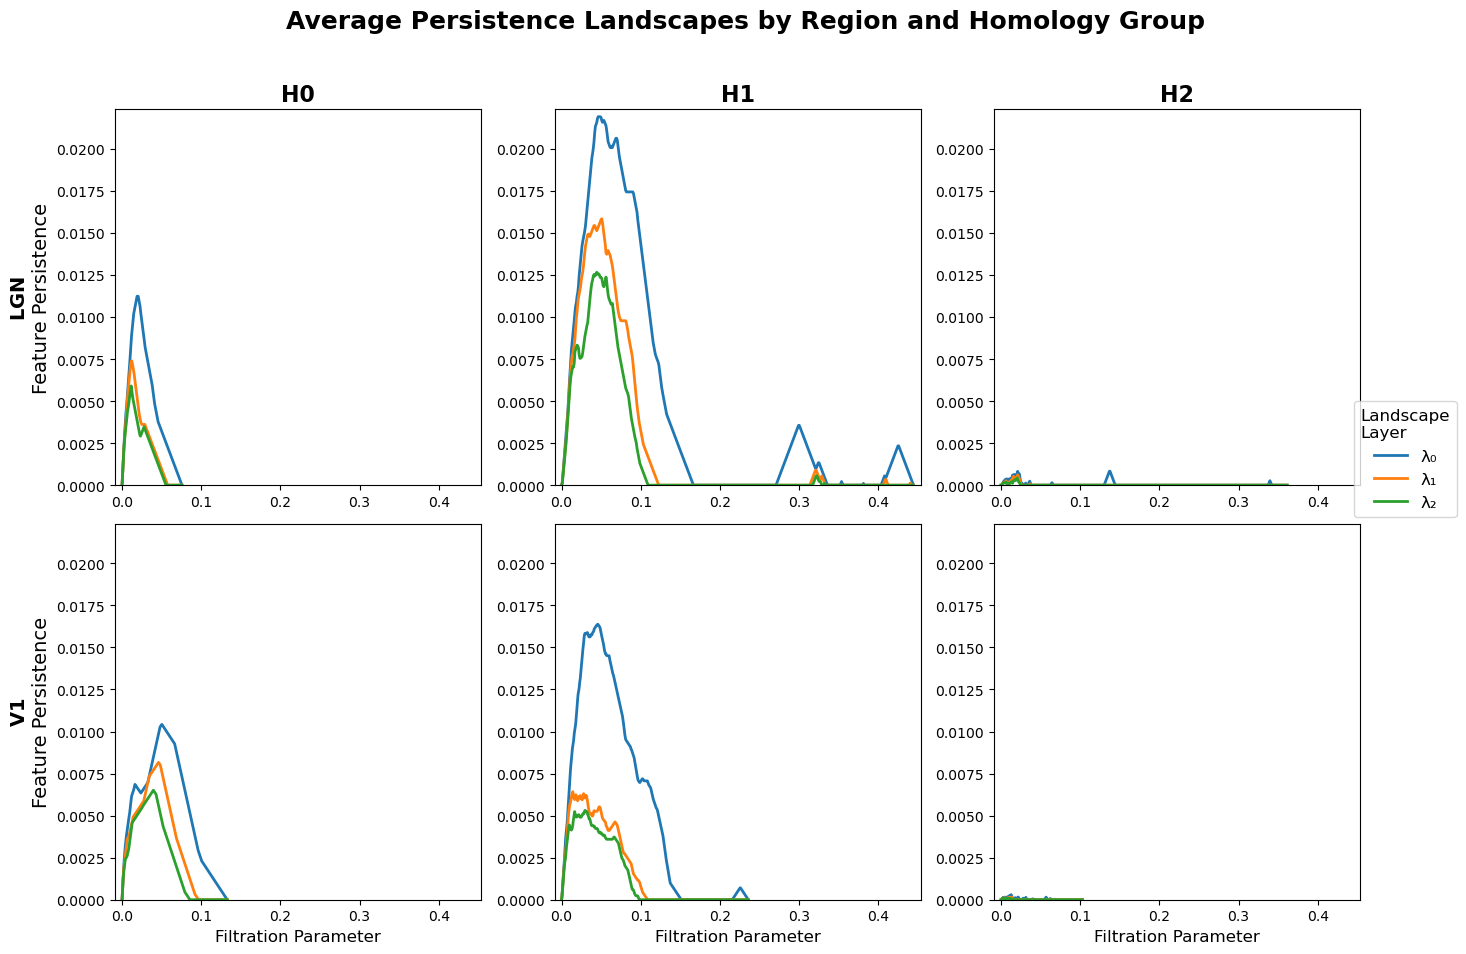

In [ ]:
# recreate the exact 2x3 plot: Average Persistence Landscapes by Region and Homology Group
if available_files:
    # collect all landscapes by region and homology degree
    region_hom_landscapes = {}
    
    for region in ['LGN', 'V1']:
        for hom_deg in range(3):  # H0, H1, H2
            print(f"Processing {region} H{hom_deg}...")
            
            # get files for this region
            region_files = [f for f in available_files if data_manager.parse_filename_info(f)['region'] == region]
            
            landscapes = []
            count = 0
            
            for file_path in region_files:
                try:
                    dgms = load_dgms(file_path)
                    if dgms is None:
                        continue
                    if isinstance(dgms, np.ndarray):
                        dgms = dgms.tolist()
                    if len(dgms) <= hom_deg:
                        continue
                    if dgms[hom_deg] is None or len(dgms[hom_deg]) == 0:
                        continue
                    
                    pl = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                    landscapes.append(pl)
                    count += 1
                    
                except Exception as e:
                    continue
            
            if landscapes:
                try:
                    avg_landscape = average_approx(landscapes)
                    region_hom_landscapes[f'{region}_H{hom_deg}'] = avg_landscape
                    print(f"  Created {region} H{hom_deg} with {count} landscapes")
                except Exception as e:
                    print(f"  Failed to average {region} H{hom_deg}: {e}")
            else:
                print(f"  No valid landscapes for {region} H{hom_deg}")
    
    # create the exact 2x3 plot
    if region_hom_landscapes:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # define colors for landscape layers (matching the original)
        layer_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green for λ0, λ1, λ2
        layer_labels = ['λ₀', 'λ₁', 'λ₂']
        
        # collect all data for consistent y-axis scaling
        all_y_values = []
        all_x_values = []
        
        landscape_data = {}
        for region_idx, region in enumerate(['LGN', 'V1']):
            for hom_idx, hom_deg in enumerate(range(3)):
                key = f'{region}_H{hom_deg}'
                if key in region_hom_landscapes:
                    landscape = region_hom_landscapes[key]
                    
                    # extract data
                    try:
                        Y = _get_Y_from_pl(landscape)
                        if Y.ndim == 1:
                            Y = Y[None, :]
                        xs = _get_xs_from_pl(landscape, n_points_hint=Y.shape[-1])
                        if Y.shape[0] == xs.size and Y.shape[1] != xs.size:
                            Y = Y.T
                        
                        landscape_data[key] = (xs, Y)
                        all_x_values.extend(xs)
                        # only use first 3 layers for scaling
                        for layer_idx in range(min(3, Y.shape[0])):
                            all_y_values.extend(Y[layer_idx])
                        
                    except Exception as e:
                        print(f"Error extracting data from {key}: {e}")
        
        # set consistent axis limits
        if all_x_values and all_y_values:
            x_min, x_max = min(all_x_values), max(all_x_values)
            y_min, y_max = 0, max(all_y_values)
            
            # add small padding
            x_padding = (x_max - x_min) * 0.02
            y_padding = y_max * 0.02
            x_min -= x_padding
            x_max += x_padding
            y_max += y_padding
        else:
            x_min, x_max, y_min, y_max = 0, 1, 0, 0.03
        
        # plot each subplot
        for region_idx, region in enumerate(['LGN', 'V1']):
            for hom_idx, hom_deg in enumerate(range(3)):
                ax = axes[region_idx, hom_idx]
                key = f'{region}_H{hom_deg}'
                
                if key in landscape_data:
                    xs, Y = landscape_data[key]
                    
                    # plot first 3 landscape layers
                    for layer_idx in range(min(3, Y.shape[0])):
                        ax.plot(xs, Y[layer_idx], 
                               color=layer_colors[layer_idx], 
                               linewidth=2,
                               label=layer_labels[layer_idx])
                else:
                    # no data available
                    ax.text(0.5, 0.5, 'No data\navailable', 
                           ha='center', va='center', transform=ax.transAxes,
                           fontsize=12, alpha=0.7)
                
                # set axis properties
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(y_min, y_max)
                ax.grid(False)
                
                # labels and titles
                if region_idx == 0:  # top row
                    ax.set_title(f'H{hom_deg}', fontsize=16, fontweight='bold')
                if hom_idx == 0:  # left column
                    ax.set_ylabel(f'$\\bf{{{region}}}$\nFeature Persistence', fontsize=14)
                if region_idx == 1:  # bottom row
                    ax.set_xlabel('Filtration Parameter', fontsize=12)
                
                # tick parameters
                ax.tick_params(axis='both', labelsize=10)
        
        # create legend (only show if we have data)
        if landscape_data:
            handles = [plt.Line2D([0], [0], color=layer_colors[i], linewidth=2, label=layer_labels[i]) for i in range(3)]
            fig.legend(handles, layer_labels, loc='center right', bbox_to_anchor=(0.98, 0.5),
                      title='Landscape\nLayer', fontsize=12, title_fontsize=12)
        
        # main title
        fig.suptitle('Average Persistence Landscapes by Region and Homology Group', 
                    fontsize=18, fontweight='bold', y=0.95)
        
        plt.tight_layout(rect=[0, 0, 0.92, 0.93])
        plt.show()
        
    else:
        print("No landscapes available for plotting by region and homology group.")
        
else:
    print("No files available for landscape computation.")

Processing LGN color_exchange H0...
  Created LGN color_exchange with 8 landscapes
Processing LGN luminance_flash H0...
  No valid landscapes for LGN luminance_flash
Processing LGN drifting_gratings H0...
  No valid landscapes for LGN drifting_gratings
Processing LGN chromatic_gratings H0...
  No valid landscapes for LGN chromatic_gratings
Processing V1 color_exchange H0...
  Created LGN color_exchange with 8 landscapes
Processing LGN luminance_flash H0...
  No valid landscapes for LGN luminance_flash
Processing LGN drifting_gratings H0...
  No valid landscapes for LGN drifting_gratings
Processing LGN chromatic_gratings H0...
  No valid landscapes for LGN chromatic_gratings
Processing V1 color_exchange H0...
  Created V1 color_exchange with 14 landscapes
Processing V1 luminance_flash H0...
  No valid landscapes for V1 luminance_flash
Processing V1 drifting_gratings H0...
  No valid landscapes for V1 drifting_gratings
Processing V1 chromatic_gratings H0...
  No valid landscapes for V1 c

Processing LGN color_exchange H0...
  Created LGN color_exchange with 8 landscapes
Processing LGN luminance_flash H0...
  No valid landscapes for LGN luminance_flash
Processing LGN drifting_gratings H0...
  No valid landscapes for LGN drifting_gratings
Processing LGN chromatic_gratings H0...
  No valid landscapes for LGN chromatic_gratings
Processing V1 color_exchange H0...
  Created LGN color_exchange with 8 landscapes
Processing LGN luminance_flash H0...
  No valid landscapes for LGN luminance_flash
Processing LGN drifting_gratings H0...
  No valid landscapes for LGN drifting_gratings
Processing LGN chromatic_gratings H0...
  No valid landscapes for LGN chromatic_gratings
Processing V1 color_exchange H0...
  Created V1 color_exchange with 14 landscapes
Processing V1 luminance_flash H0...
  No valid landscapes for V1 luminance_flash
Processing V1 drifting_gratings H0...
  No valid landscapes for V1 drifting_gratings
Processing V1 chromatic_gratings H0...
  No valid landscapes for V1 c

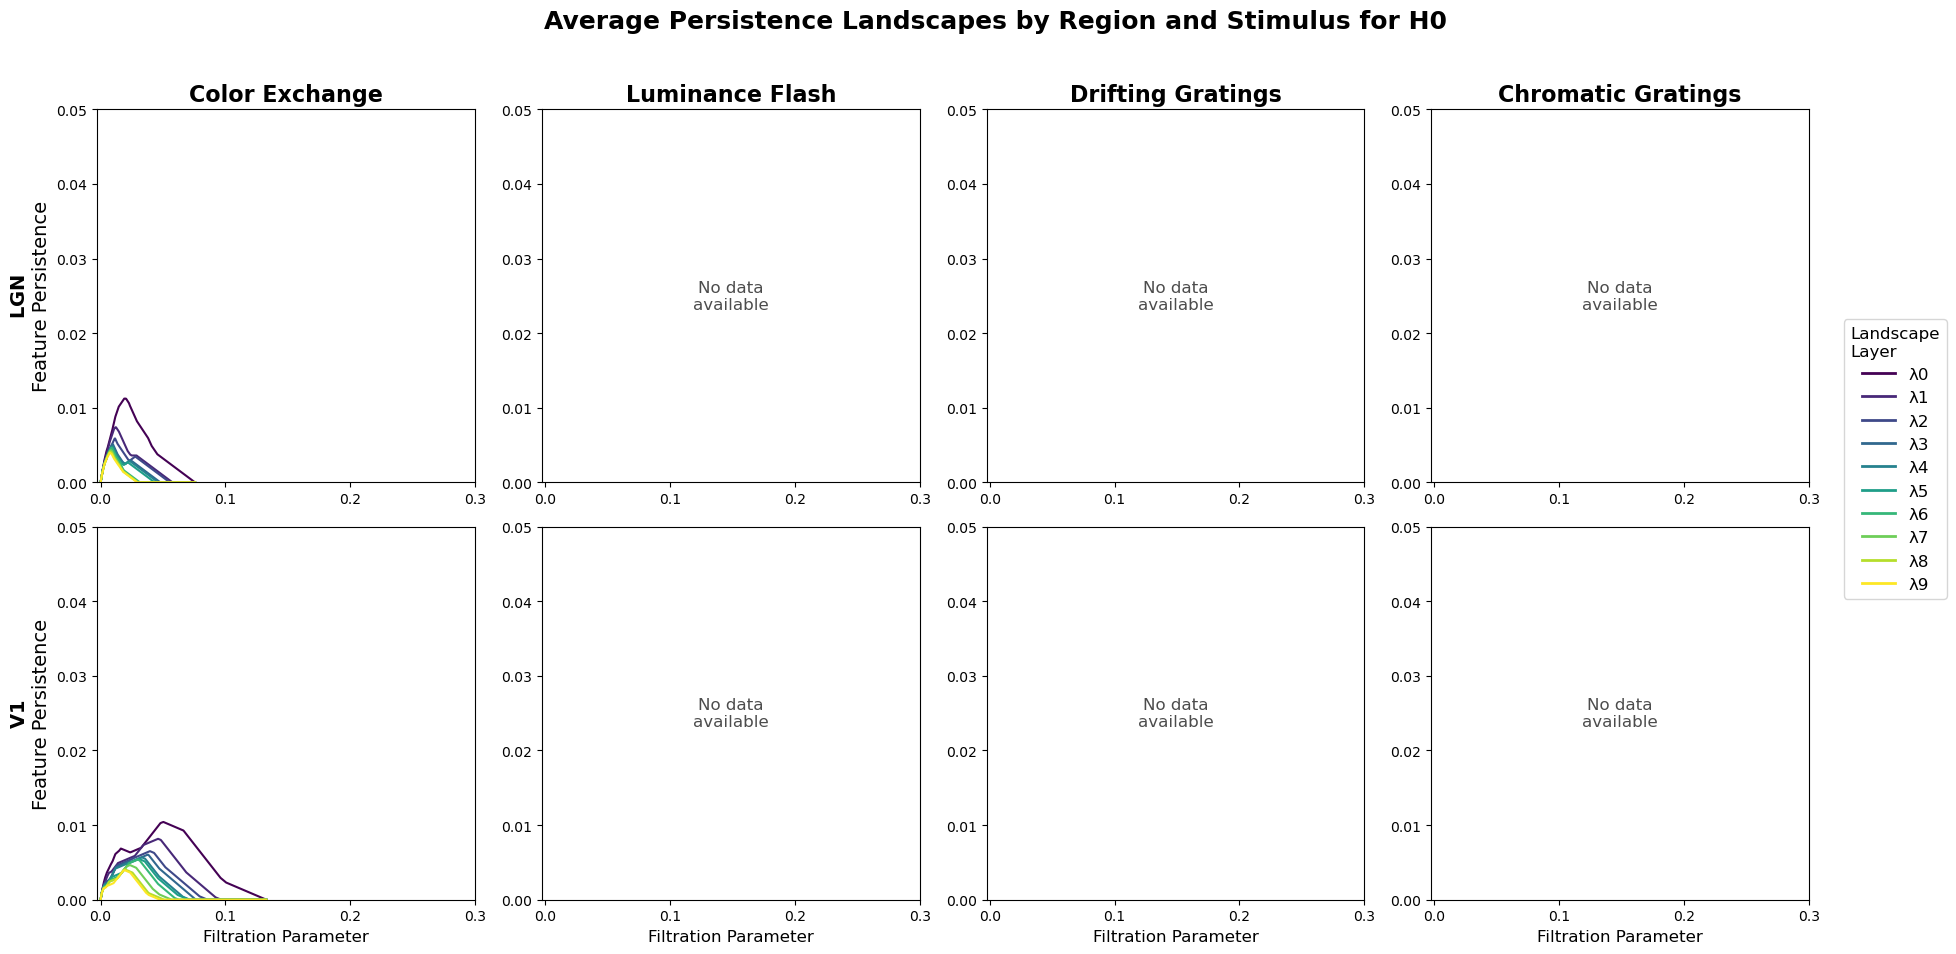

In [ ]:
# recreate the exact 2x4 plot: Average Persistence Landscapes by Region and Stimulus
# with selectable homology degree

# SELECT HOMOLOGY DEGREE HERE:
selected_hom_deg = 0  # Change this to 0, 1, or 2 for H0, H1, or H2

if available_files:
    # define the 4 stimuli we want to plot (matching the order in the image)
    target_stimuli = ['color_exchange', 'luminance_flash', 'drifting_gratings', 'chromatic_gratings']
    stimulus_title_map = {
        'color_exchange': 'Color Exchange',
        'luminance_flash': 'Luminance Flash', 
        'drifting_gratings': 'Drifting Gratings',
        'chromatic_gratings': 'Chromatic Gratings'
    }
    
    # collect landscapes by region and stimulus for the selected homology degree
    region_stim_landscapes = {}
    
    for region in ['LGN', 'V1']:
        for stimulus in target_stimuli:
            print(f"Processing {region} {stimulus} H{selected_hom_deg}...")
            
            # get files for this region and stimulus
            matching_files = [f for f in available_files 
                            if (data_manager.parse_filename_info(f)['region'] == region and 
                                data_manager.parse_filename_info(f)['stimulus'] == stimulus)]
            
            landscapes = []
            count = 0
            
            for file_path in matching_files:
                try:
                    dgms = load_dgms(file_path)
                    if dgms is None:
                        continue
                    if isinstance(dgms, np.ndarray):
                        dgms = dgms.tolist()
                    if len(dgms) <= selected_hom_deg:
                        continue
                    if dgms[selected_hom_deg] is None or len(dgms[selected_hom_deg]) == 0:
                        continue
                    
                    pl = PersLandscapeApprox(dgms=dgms, hom_deg=selected_hom_deg)
                    landscapes.append(pl)
                    count += 1
                    
                except Exception as e:
                    continue
            
            if landscapes:
                try:
                    avg_landscape = average_approx(landscapes)
                    region_stim_landscapes[f'{region}_{stimulus}'] = avg_landscape
                    print(f"  Created {region} {stimulus} with {count} landscapes")
                except Exception as e:
                    print(f"  Failed to average {region} {stimulus}: {e}")
            else:
                print(f"  No valid landscapes for {region} {stimulus}")
    
    # create the exact 2x4 plot
    if region_stim_landscapes:
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        
        # define colors for 10 landscape layers (matching the viridis-like colormap)
        layer_colors = plt.cm.viridis(np.linspace(0, 1, 10))
        layer_labels = [f'λ{i}' for i in range(10)]
        
        # collect all data for consistent axis scaling
        all_y_values = []
        all_x_values = []
        
        landscape_data = {}
        for region_idx, region in enumerate(['LGN', 'V1']):
            for stim_idx, stimulus in enumerate(target_stimuli):
                key = f'{region}_{stimulus}'
                if key in region_stim_landscapes:
                    landscape = region_stim_landscapes[key]
                    
                    # extract data
                    try:
                        Y = _get_Y_from_pl(landscape)
                        if Y.ndim == 1:
                            Y = Y[None, :]
                        xs = _get_xs_from_pl(landscape, n_points_hint=Y.shape[-1])
                        if Y.shape[0] == xs.size and Y.shape[1] != xs.size:
                            Y = Y.T
                        
                        landscape_data[key] = (xs, Y)
                        all_x_values.extend(xs)
                        # use first 10 layers for scaling
                        for layer_idx in range(min(10, Y.shape[0])):
                            all_y_values.extend(Y[layer_idx])
                        
                    except Exception as e:
                        print(f"Error extracting data from {key}: {e}")
        
        # set consistent axis limits
        if all_x_values and all_y_values:
            x_min, x_max = min(all_x_values), max(all_x_values)
            y_min, y_max = 0, max(all_y_values)
            
            # add small padding
            x_padding = (x_max - x_min) * 0.02
            y_padding = y_max * 0.05
            x_min -= x_padding
            x_max += x_padding
            y_max += y_padding
        else:
            x_min, x_max, y_min, y_max = 0, 0.3, 0, 0.05
        
        # plot each subplot
        for region_idx, region in enumerate(['LGN', 'V1']):
            for stim_idx, stimulus in enumerate(target_stimuli):
                ax = axes[region_idx, stim_idx]
                key = f'{region}_{stimulus}'
                
                if key in landscape_data:
                    xs, Y = landscape_data[key]
                    
                    # plot first 10 landscape layers
                    for layer_idx in range(min(10, Y.shape[0])):
                        ax.plot(xs, Y[layer_idx], 
                               color=layer_colors[layer_idx], 
                               linewidth=1.5,
                               label=layer_labels[layer_idx])
                else:
                    # no data available
                    ax.text(0.5, 0.5, 'No data\navailable', 
                           ha='center', va='center', transform=ax.transAxes,
                           fontsize=12, alpha=0.7)
                
                # set axis properties
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(y_min, y_max)
                ax.grid(False)
                
                # labels and titles
                if region_idx == 0:  # top row
                    title = stimulus_title_map.get(stimulus, stimulus.replace('_', ' ').title())
                    ax.set_title(title, fontsize=16, fontweight='bold')
                if stim_idx == 0:  # left column
                    ax.set_ylabel(f'$\\bf{{{region}}}$\nFeature Persistence', fontsize=14)
                if region_idx == 1:  # bottom row
                    ax.set_xlabel('Filtration Parameter', fontsize=12)
                
                # tick parameters
                ax.tick_params(axis='both', labelsize=10)
                
                # set specific tick positions to match the original
                ax.set_xticks([0.0, 0.1, 0.2, 0.3])
                ax.set_yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05])
        
        # create legend with all 10 layers
        if landscape_data:
            handles = [plt.Line2D([0], [0], color=layer_colors[i], linewidth=2, label=layer_labels[i]) for i in range(10)]
            fig.legend(handles, layer_labels, loc='center right', bbox_to_anchor=(0.98, 0.5),
                      title='Landscape\nLayer', fontsize=12, title_fontsize=12, ncol=1)
        
        # main title with selected homology degree
        fig.suptitle(f'Average Persistence Landscapes by Region and Stimulus for H{selected_hom_deg}', 
                    fontsize=18, fontweight='bold', y=0.95)
        
        plt.tight_layout(rect=[0, 0, 0.92, 0.93])
        plt.show()
        
    else:
        print(f"No landscapes available for plotting by region and stimulus for H{selected_hom_deg}.")
        
else:
    print("No files available for landscape computation.")

In [16]:
# helper functions for extracting landscape data
def _get_Y_from_pl(landscape):
    """Extract Y values from persistence landscape."""
    if hasattr(landscape, 'landscapes'):
        return np.array(landscape.landscapes)
    elif hasattr(landscape, 'values'):
        return np.array(landscape.values)
    elif hasattr(landscape, 'Ls'):
        return np.array(landscape.Ls)
    else:
        raise ValueError("Could not extract Y values from landscape")

def _get_xs_from_pl(landscape, n_points_hint=None):
    """Extract X values from persistence landscape."""
    if hasattr(landscape, 'grid'):
        return landscape.grid
    elif hasattr(landscape, 'xs'):
        return landscape.xs
    elif hasattr(landscape, 'start') and hasattr(landscape, 'stop') and hasattr(landscape, 'num_steps'):
        return np.linspace(landscape.start, landscape.stop, landscape.num_steps)
    elif n_points_hint:
        return np.linspace(0, 1, n_points_hint)
    else:
        raise ValueError("Could not extract X values from landscape")

## Average PLs by stimulus and region

In [17]:
# compute average landscapes by stimulus and region for all homology degrees
if available_files:
    landscapes_by_stimulus = {}
    
    # get unique stimuli and regions
    unique_stimuli = set()
    unique_regions = set()
    for file_path in available_files:
        info = data_manager.parse_filename_info(file_path)
        unique_stimuli.add(info['stimulus'])
        unique_regions.add(info['region'])
    
    print(f"Computing landscapes for {len(unique_stimuli)} stimuli and {len(unique_regions)} regions")
    
    for region in unique_regions:
        for stimulus in unique_stimuli:
            for hom_deg in range(3):
                key = f"{region}_{stimulus}_H{hom_deg}"
                print(f"Processing {key}...")
                
                # get matching files
                matching_files = [f for f in available_files 
                                if (data_manager.parse_filename_info(f)['region'] == region and 
                                    data_manager.parse_filename_info(f)['stimulus'] == stimulus)]
                
                landscapes = []
                count = 0
                
                for file_path in matching_files:
                    try:
                        dgms = load_dgms(file_path)
                        if dgms is None:
                            continue
                        if isinstance(dgms, np.ndarray):
                            dgms = dgms.tolist()
                        if len(dgms) <= hom_deg:
                            continue
                        if dgms[hom_deg] is None or len(dgms[hom_deg]) == 0:
                            continue
                        
                        pl = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                        landscapes.append(pl)
                        count += 1
                        
                    except Exception as e:
                        continue
                
                if landscapes:
                    try:
                        avg_landscape = average_approx(landscapes)
                        landscapes_by_stimulus[key] = avg_landscape
                        print(f"  Created with {count} landscapes")
                    except Exception as e:
                        print(f"  Failed to average: {e}")
                else:
                    print(f"  No valid landscapes")
    
    print(f"\nTotal landscapes by stimulus created: {len(landscapes_by_stimulus)}")
    
else:
    print("No files available for stimulus-based landscape computation.")
    landscapes_by_stimulus = {}

Computing landscapes for 1 stimuli and 2 regions
Processing LGN_color_exchange_H0...
  Created with 8 landscapes
Processing LGN_color_exchange_H1...
  Created with 8 landscapes
Processing LGN_color_exchange_H2...
  Created with 8 landscapes
Processing LGN_color_exchange_H1...
  Created with 8 landscapes
Processing LGN_color_exchange_H2...
  Created with 8 landscapes
Processing V1_color_exchange_H0...
  Created with 8 landscapes
Processing V1_color_exchange_H0...
  Created with 14 landscapes
Processing V1_color_exchange_H1...
  Created with 14 landscapes
Processing V1_color_exchange_H1...
  Created with 14 landscapes
Processing V1_color_exchange_H2...
  Created with 14 landscapes

Total landscapes by stimulus created: 6
  Created with 14 landscapes
Processing V1_color_exchange_H2...
  Created with 14 landscapes

Total landscapes by stimulus created: 6


Processing LGN color_exchange H1...
  Created color_exchange with 8 landscapes
Processing LGN luminance_flash H1...
  No valid landscapes for luminance_flash
Processing LGN drifting_gratings H1...
  No valid landscapes for drifting_gratings
Processing LGN chromatic_gratings H1...
  No valid landscapes for chromatic_gratings


Processing LGN color_exchange H1...
  Created color_exchange with 8 landscapes
Processing LGN luminance_flash H1...
  No valid landscapes for luminance_flash
Processing LGN drifting_gratings H1...
  No valid landscapes for drifting_gratings
Processing LGN chromatic_gratings H1...
  No valid landscapes for chromatic_gratings


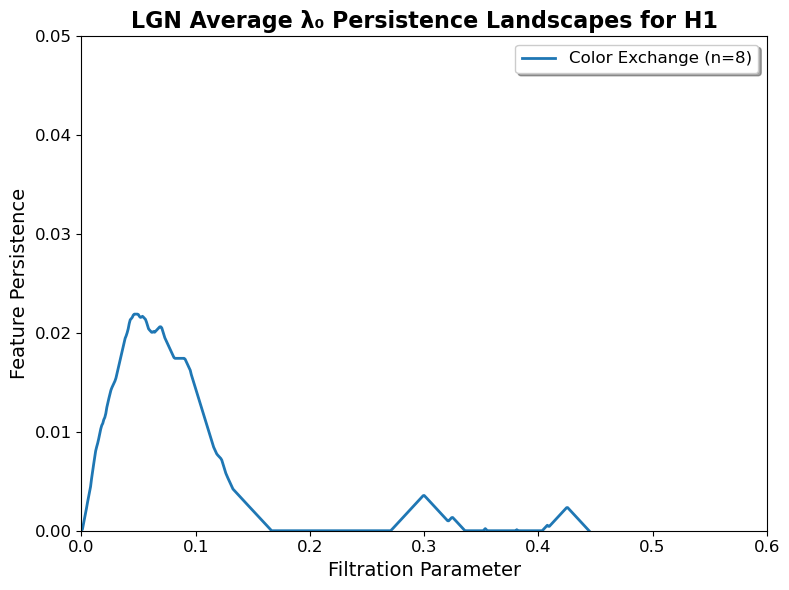

In [19]:
# recreate the exact overlay plot: Average λ₀ Persistence Landscapes by Stimulus
# with selectable region and homology degree

# SELECT PARAMETERS HERE:
selected_region = 'LGN'  # Change this to 'LGN' or 'V1'
selected_hom_deg = 1     # Change this to 0, 1, or 2 for H0, H1, or H2

if available_files:
    # define the 4 stimuli we want to plot
    target_stimuli = ['color_exchange', 'luminance_flash', 'drifting_gratings', 'chromatic_gratings']
    stimulus_title_map = {
        'color_exchange': 'Color Exchange',
        'luminance_flash': 'Luminance Flash', 
        'drifting_gratings': 'Drifting Gratings',
        'chromatic_gratings': 'Chromatic Gratings'
    }
    
    # define colors for each stimulus (matching the image)
    stimulus_colors = {
        'color_exchange': '#1f77b4',     # blue
        'luminance_flash': '#ff7f0e',    # orange
        'drifting_gratings': '#2ca02c',  # green
        'chromatic_gratings': '#d62728'  # red/brown
    }
    
    # collect landscapes by stimulus for the selected region and homology degree
    stimulus_landscapes = {}
    stimulus_counts = {}
    
    for stimulus in target_stimuli:
        print(f"Processing {selected_region} {stimulus} H{selected_hom_deg}...")
        
        # get files for this region and stimulus
        matching_files = [f for f in available_files 
                        if (data_manager.parse_filename_info(f)['region'] == selected_region and 
                            data_manager.parse_filename_info(f)['stimulus'] == stimulus)]
        
        landscapes = []
        count = 0
        
        for file_path in matching_files:
            try:
                dgms = load_dgms(file_path)
                if dgms is None:
                    continue
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                if len(dgms) <= selected_hom_deg:
                    continue
                if dgms[selected_hom_deg] is None or len(dgms[selected_hom_deg]) == 0:
                    continue
                
                pl = PersLandscapeApprox(dgms=dgms, hom_deg=selected_hom_deg)
                landscapes.append(pl)
                count += 1
                
            except Exception as e:
                continue
        
        if landscapes:
            try:
                avg_landscape = average_approx(landscapes)
                stimulus_landscapes[stimulus] = avg_landscape
                stimulus_counts[stimulus] = count
                print(f"  Created {stimulus} with {count} landscapes")
            except Exception as e:
                print(f"  Failed to average {stimulus}: {e}")
        else:
            print(f"  No valid landscapes for {stimulus}")
    
    # create the exact overlay plot
    if stimulus_landscapes:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        
        # plot each stimulus as an overlay
        for stimulus in target_stimuli:
            if stimulus in stimulus_landscapes:
                landscape = stimulus_landscapes[stimulus]
                count = stimulus_counts[stimulus]
                
                try:
                    # extract data
                    Y = _get_Y_from_pl(landscape)
                    if Y.ndim == 1:
                        Y = Y[None, :]
                    xs = _get_xs_from_pl(landscape, n_points_hint=Y.shape[-1])
                    if Y.shape[0] == xs.size and Y.shape[1] != xs.size:
                        Y = Y.T
                    
                    # plot only the first landscape layer (λ₀)
                    if Y.shape[0] > 0:
                        stimulus_label = stimulus_title_map.get(stimulus, stimulus.replace('_', ' ').title())
                        ax.plot(xs, Y[0], 
                               color=stimulus_colors[stimulus],
                               linewidth=2,
                               label=f'{stimulus_label} (n={count})')
                    
                except Exception as e:
                    print(f"Error plotting {stimulus}: {e}")
        
        # set axis properties to match the original
        ax.set_xlim(0.0, 0.6)
        ax.set_ylim(0.0, 0.05)
        ax.grid(False)
        
        # set specific tick positions to match the original
        ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
        ax.set_yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05])
        
        # labels and title
        ax.set_xlabel('Filtration Parameter', fontsize=14)
        ax.set_ylabel('Feature Persistence', fontsize=14)
        ax.set_title(f'{selected_region} Average λ₀ Persistence Landscapes for H{selected_hom_deg}', 
                    fontsize=16, fontweight='bold')
        
        # legend
        ax.legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, shadow=True)
        
        # tick parameters
        ax.tick_params(axis='both', labelsize=12)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"No landscapes available for plotting {selected_region} H{selected_hom_deg}.")
        
else:
    print("No files available for landscape computation.")